In [ ]:
#!pip install scipy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import pymc3 as pm
from scipy.stats import ttest_ind

In [ ]:
data = pd.read_csv('/content/Training_set_advance.csv')
data

,ID_Patient_Care_Situation,Diagnosed_Condition,Patient_ID,Treated_with_drugs,Patient_Age,Patient_Body_Mass_Index,Patient_Smoker,Patient_Rural_Urban,Patient_mental_condition,A,B,C,D,E,F,Z,Number_of_prev_cond,Survived_1_year
0,1,1,5327,DX6,27,26.722301,YES,RURAL,Stable,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
1,2,32,12157,DX2 DX3,32,18.622978,YES,RURAL,Stable,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0
2,3,3,9024,dx2,45,25.846438,NO,URBAN,Stable,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1
3,4,50,7574,DX6,39,23.864199,NO,RURAL,Stable,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,1
4,5,20,10218,DX2,21,18.959904,YES,RURAL,Stable,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30006,33010,0,12511,NaN,142,1.570100,Cannot say,RURAL,Stable,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
30007,33011,0,12512,NaN,132,1.989600,Cannot say,RURAL,Stable,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
30008,33012,0,12513,NaN,128,1.348400,Cannot say,RURAL,Stable,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
30009,33013,0,12514,NaN,121,1.089300,Cannot say,RURAL,Stable,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1


In [ ]:
# pretend everything is randomized enough. We only want to test survival of urban vs. rural patients
use_data = data[['Patient_Rural_Urban','Survived_1_year']].copy()
use_data ['Patient_Rural_Urban'].unique()

array(['RURAL', 'URBAN'], dtype=object)

In [ ]:
use_data['urban'] = 0
use_data.loc[use_data['Patient_Rural_Urban']=='URBAN','urban']=1
use_data.head()

,Patient_Rural_Urban,Survived_1_year,urban
0,RURAL,1,0
1,RURAL,0,0
2,URBAN,1,1
3,RURAL,1,0
4,RURAL,0,0


In [ ]:
urban= use_data.loc[use_data['urban']==1, 'Survived_1_year'].values
rural= use_data.loc[use_data['urban']==0, 'Survived_1_year'].values
print(f'Urban Observation: {urban.shape[0]}')
print(f'Rural Observation: {rural.shape[0]}')

Urban Observation: 9048
Rural Observation: 20963


In [ ]:
#mean values
print(f'Urban Survival Rate: {np.mean(urban):.1%}')
print(f'Rural Survival Rate: {np.mean(rural):.1%}')

Urban Survival Rate: 54.8%
Rural Survival Rate: 66.9%


In [ ]:
#traditional method
print(f'P-value: {ttest_ind(urban, rural, equal_var=False, alternative="two-sided").pvalue:0.5%}')

P-value: 0.00000%


In [ ]:
#Bayesian method

with pm.Model():
  #prior
  urban_rate = pm.Beta('urban_rate', 5,5)
  rural_rate = pm.Beta('rural_rate', 5,5)

  #model
  urban_obs = pm.Bernoulli('urban_obs', urban_rate, observed=urban)
  rural_obs = pm.Bernoulli('rural_obs', rural_rate, observed=rural)

  trace = pm.sample(return_inferencedata=True)

In [ ]:
import arviz as ax

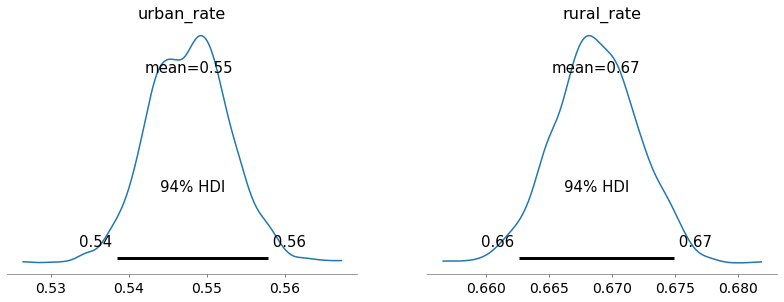

In [ ]:
ax.plot_posterior(trace);

In [ ]:
urban_samples = trace.posterior['urban_rate'].values
rural_samples = trace.posterior['rural_rate'].values

print(f'Probability that Rural Patients survives at a higher rate than Urban Patients: {(rural_samples>urban_samples).mean():.5%}')

Probability that Rural Patients survives at a higher rate than Urban Patients: 100.00000%


### Attempt with Multiple Factors

We are going to use MCMC sampling (from PyMC3) for a linear regression. Yes, the dependent variable is binary and yes it makes sense to use logistic regression instead of linear.. but we are going to do linear first

In [ ]:
multi_data = data[['Patient_Smoker','Patient_Rural_Urban','Survived_1_year']].copy()
multi_data['Patient_Smoker'].unique()

array(['YES', 'NO', 'NO ', 'YES ', 'YESS', 'YESS ', 'Cannot say',
       'CANNOT SAY ', 'CANNOT SAY', 'Cannot say '], dtype=object)

In [ ]:
multi_data.loc[multi_data['Patient_Smoker']=="NO",'Patient_Smoker']='NO'
multi_data.loc[multi_data['Patient_Smoker']=="YES",'Patient_Smoker']='YES'
multi_data.loc[multi_data['Patient_Smoker']=="YESS",'Patient_Smoker']='YES'
multi_data.loc[multi_data['Patient_Smoker']=='YESS ','Patient_Smoker']='YES'
multi_data =multi_data[(multi_data['Patient_Smoker']=="NO")|(multi_data['Patient_Smoker']=="YES")]

multi_data['smoker']= [0 if i =="NO" else 1 for i in multi_data['Patient_Smoker']]
multi_data['urban']= [0 if i =="RURAL" else 1 for i in multi_data['Patient_Rural_Urban']]


multi_data['urban_smoker'] = multi_data['smoker']*multi_data['urban']

multi_data['urban_nonsmoker'] = 0
multi_data.loc[(multi_data['smoker']==0)& (multi_data['urban']==1), 'urban_nonsmoker']=1


multi_data['rural_smoker'] = 0
multi_data.loc[(multi_data['smoker']==1)& (multi_data['urban']==0), 'rural_smoker']=1


multi_data.head()

,Patient_Smoker,Patient_Rural_Urban,Survived_1_year,smoker,urban,urban_smoker,urban_nonsmoker,rural_smoker
0,YES,RURAL,1,1,0,0,0,1
1,YES,RURAL,0,1,0,0,0,1
2,NO,URBAN,1,0,1,0,1,0
3,NO,RURAL,1,0,0,0,0,0
4,YES,RURAL,0,1,0,0,0,1


In [ ]:
urban_smoker = multi_data['urban_smoker'].values
urban_nonsmoker = multi_data['urban_nonsmoker'].values
rural_smoker = multi_data['rural_smoker'].values
survived = multi_data['Survived_1_year'].values

$\hat{y}= α + β_1 × (urban\;smoker)+ β_2 × (urban\;nonsmoker)+ β_3 × (rural\;smoker)+ ϵ$

In [ ]:
with pm.Model():
  #prior
  alpha = pm.Normal('alpha', 0,1)
  beta1 = pm.Normal('beta1', 0,1)
  beta2 = pm.Normal('beta2', 0,1)
  beta3 = pm.Normal('beta3', 0,1)
  sigma = pm.HalfNormal('sigma',1)

  #model
  mu = alpha + beta1*urban_smoker + beta2*urban_nonsmoker + beta3*rural_smoker
  y = pm.Normal('y',mu, sigma, observed= survived)

  #sample
  trace = pm.sample(return_inferencedata=True)

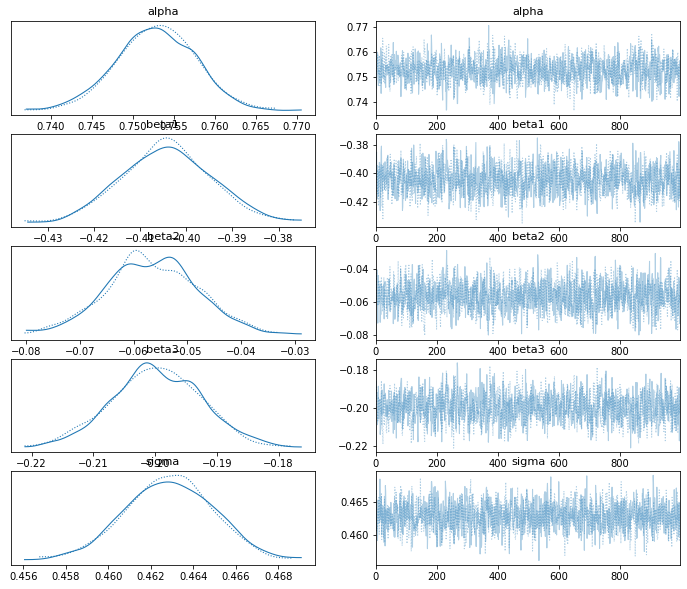

In [ ]:
ax.plot_trace(trace);

In [ ]:
display(ax.summary(trace, round_to=4))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.7528,0.0048,0.7433,0.7611,0.0001,0.0001,1090.8571,1299.2160,1.0003
beta1,-0.4043,0.0097,-0.4232,-0.3866,0.0003,0.0002,1370.0059,1460.6397,1.0000
beta2,-0.0565,0.0086,-0.0724,-0.0399,0.0002,0.0002,1372.3505,1520.6395,0.9997
beta3,-0.1997,0.0072,-0.2136,-0.1866,0.0002,0.0001,1242.9876,1474.8236,0.9997
sigma,0.4629,0.0021,0.4591,0.4667,0.0001,0.0000,1601.6698,1422.5414,1.0001


In [ ]:
beta1_sample =trace.posterior['beta1'].values
beta2_sample =trace.posterior['beta2'].values
beta3_sample =trace.posterior['beta3'].values



print('Probability that each coefficient is positive')
print('(Probability that each group survives more than Rural Non-Smokers)')
print(f'Urban Smoker:{(beta1_sample>=0).mean():.5%}')
print(f'Urban NonSmoker:{(beta2_sample>=0).mean():.5%}')
print(f'Rural Smoker:{(beta3_sample>=0).mean():.5%}')

Probability that each coefficient is positive
(Probability that each group survives more than Rural Non-Smokers)
Urban Smoker:0.00000%
Urban NonSmoker:0.00000%
Rural Smoker:0.00000%


In [ ]:
from pickle import TRUE
#using a formula

with pm.Model() as model:
  pm.glm.GLM.from_formula('Survived_1_year~smoker + urban + smoker:urban',multi_data)

  trace = pm.sample(4000, return_inferencedata=True)

We recommend to instead use Bambi https://bambinos.github.io/bambi/


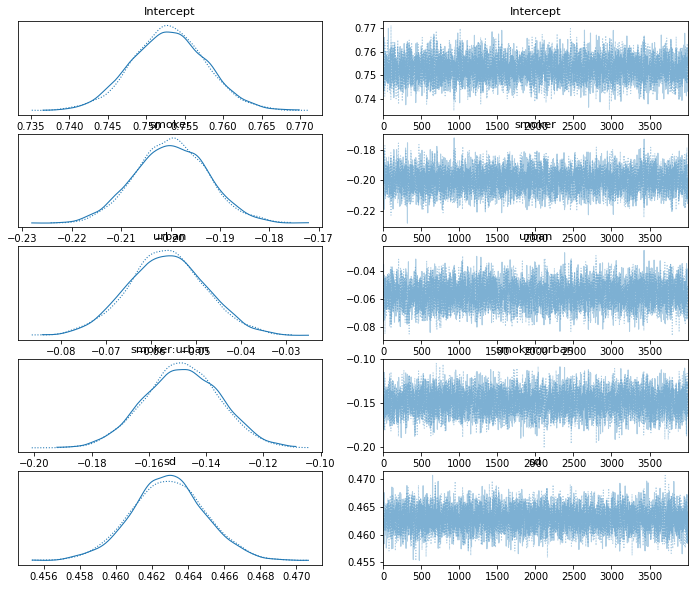

In [ ]:
ax.plot_trace(trace);

In [ ]:
display(ax.summary(trace, round_to=4))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.7530,0.0048,0.7440,0.7620,0.0001,0.0000,4862.6464,5401.3135,1.0003
smoker,-0.1998,0.0073,-0.2134,-0.1863,0.0001,0.0001,4907.8659,5205.5931,1.0008
urban,-0.0565,0.0087,-0.0729,-0.0403,0.0001,0.0001,4745.9585,5193.0900,1.0002
smoker:urban,-0.1484,0.0132,-0.1739,-0.1245,0.0002,0.0001,5028.6421,4974.0987,1.0005
sd,0.4629,0.0020,0.4590,0.4668,0.0000,0.0000,7327.7932,5851.7050,1.0002


In [ ]:
#traditional

import statsmodels.api as sm
from statsmodels.formula.api import ols

trad_lm = ols('Survived_1_year~smoker + urban + smoker:urban',data=multi_data).fit()
trad_anova = sm.stats.anova_lm(trad_lm)
trad_lm.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Survived_1_year   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     693.4
Date:                Thu, 11 Aug 2022   Prob (F-statistic):               0.00
Time:                        05:59:36   Log-Likelihood:                -15516.
No. Observations:               23926   AIC:                         3.104e+04
Df Residuals:                   23922   BIC:                         3.107e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.7530      0.005    158.240      0.000       0.744       0.762
smoker          -0.1998      0.007    -27.664      0.000      -0.214      -0.186
urban           -0.0567      0.009     -6.585      0.000      -0.074      -0.040
smoker:urban    -0.1482      0.013    -11.233      0.000      -0.174      -0.122
==============================================================================
Omnibus:                   285155.914   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2935.389
Skew:                          -0.513   Prob(JB):                         0.00
Kurtosis:                       1.625   Cond. No.                         6.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
trad_anova

,df,sum_sq,mean_sq,F,PR(>F)
smoker,1.0,346.452088,346.452088,1617.199540,0.000000e+00
urban,1.0,72.178674,72.178674,336.921967,9.742654e-75
smoker:urban,1.0,27.029575,27.029575,126.171029,3.338330e-29
Residual,23922.0,5124.801629,0.214230,NaN,NaN


### Logistic Multiple Regression

In [ ]:
# The easy way
with pm.Model() as model:
  pm.glm.GLM.from_formula('Survived_1_year~smoker + urban + smoker:urban',multi_data,family='binomial')

  trace = pm.sample(4000,tune=2000, return_inferencedata=True)



We recommend to instead use Bambi https://bambinos.github.io/bambi/


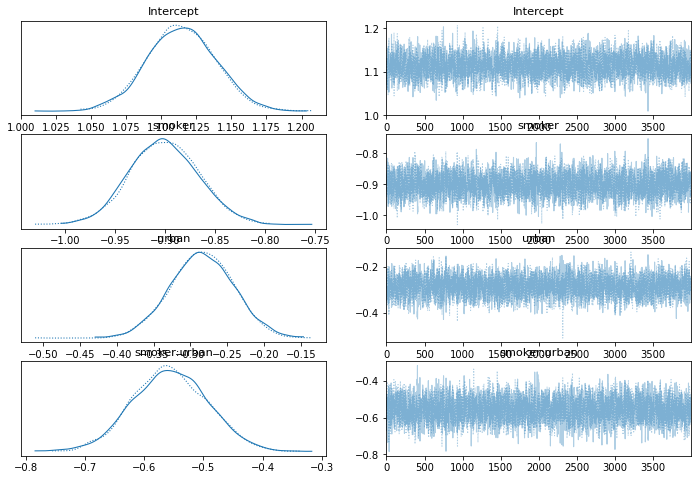

In [ ]:
ax.plot_trace(trace);

In [ ]:
display(ax.summary(trace, round_to=4))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.1144,0.0243,1.0699,1.1607,0.0004,0.0003,3407.8140,4105.6781,1.0002
smoker,-0.9007,0.0343,-0.9636,-0.8351,0.0006,0.0004,3490.7753,4178.6988,1.0000
urban,-0.2843,0.0428,-0.3639,-0.2017,0.0007,0.0005,3299.5494,3630.5981,1.0001
smoker:urban,-0.5560,0.0629,-0.6697,-0.4349,0.0011,0.0008,3513.8274,4569.6765,1.0009


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<Figure size 864x576 with 0 Axes>

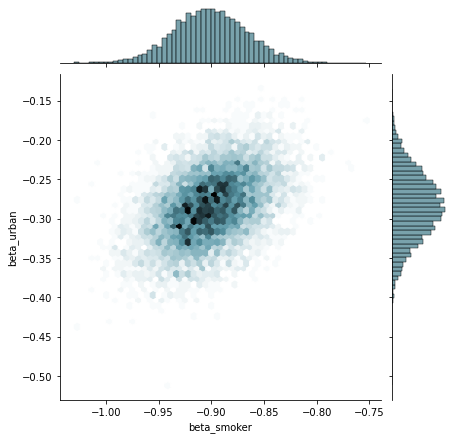

In [ ]:
smoker_post = np.concatenate([trace.posterior['smoker'][0].values, trace.posterior['smoker'][1].values])
urban_post = np.concatenate([trace.posterior['urban'][0].values, trace.posterior['urban'][1].values])


plt.figure(figsize=(12,8))
sns.jointplot(x=smoker_post, y= urban_post, kind = "hex",color="#4C8391")
plt.xlabel("beta_smoker")
plt.ylabel("beta_urban");

In [ ]:
intercept = np.concatenate([trace.posterior['Intercept'][0].values, trace.posterior['Intercept'][1].values])
smoker_urban_post = np.concatenate([trace.posterior['smoker:urban'][0].values, trace.posterior['smoker:urban'][1].values])


smoker = multi_data['smoker'].values
urban = multi_data['urban'].values

In [ ]:
sample = np.random.choice(range(len(intercept)), size=100)
means = [intercept[i]+ smoker*smoker_post[i]+ urban*urban_post[i]+ smoker*urban*smoker_urban_post[i] for i in sample]
probs = [1 /(1+np.exp(-i)) for i in means]
all_probs = probs[0]
for i in range(1, len(probs)):
  all_probs = np.concatenate([all_probs, probs[i]])

In [ ]:
smoker_plot =np.resize(smoker,all_probs.shape[0])
urban_plot =np.resize(urban,all_probs.shape[0])

In [ ]:
scatter = pd.DataFrame([urban_plot,smoker_plot,all_probs])
scatter = scatter.T
scatter.columns = ['Urban','Smoker',"Probability"]

In [ ]:
scatter['Patient Type'] = 'Rural Non-Smoker'
scatter.loc[(scatter['Urban']==1) & (scatter['Smoker']==0), 'Patient Type' ] = 'Urban Non-Smoker'
scatter.loc[(scatter['Urban']==0) & (scatter['Smoker']==1), 'Patient Type' ] = 'Rural Smoker'
scatter.loc[(scatter['Urban']==1) & (scatter['Smoker']==1), 'Patient Type' ] = 'Urban Smoker'

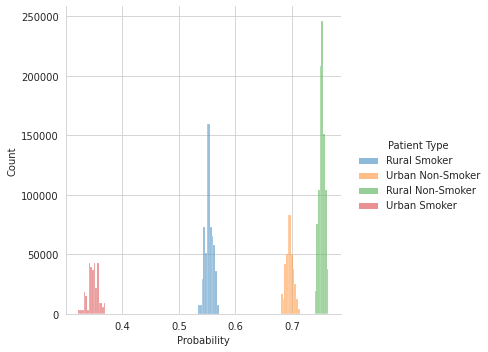

In [ ]:
sns.set_style('whitegrid')
sns.displot(data = scatter, x = "Probability", hue="Patient Type")